In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
import sys 
sys.path.append('..')
from renderer import render

In [2]:
np.set_printoptions(suppress=True)
TIME_COLUMN_INDEX = 0
OPEN_COLUMN_INDEX = 1
CLOSE_COLUMN_INDEX = 4
VOLUME_COLUMN_INDEX = 5
EPISODE_SIZE = 720
LOOK_AHEAD = 15
FILTER_PADDING = 4
TRAIN_SPLIT = 0.85

In [3]:
def read_data(filename="../data/bitfinex-BTCUSD-1m.csv", date_columns="DateTime"):
    df = pd.read_csv(filename, parse_dates=[date_columns])
    df = df[~np.isnan(df['Close'])].set_index(pd.DatetimeIndex(df[date_columns]))
    df['Volume'] = ((df['Volume'] - df['Volume'].mean())/df['Volume'].std())
    return df

def normalize_episode(df_episode):
    df_episode_norm = df_episode.copy()
    df_episode_norm['Open']  = df_episode_norm['Open'] / df_episode.iloc[0]['Open']
    df_episode_norm['High']  = df_episode_norm['High'] / df_episode.iloc[0]['Open']
    df_episode_norm['Low']   = df_episode_norm['Low']  / df_episode.iloc[0]['Open']
    df_episode_norm['Close'] = df_episode_norm['Close']/df_episode.iloc[0]['Open']
    return df_episode_norm

def get_train_test_sets(df, train_split):
    state_len = df.shape[0]
    train_end_index = int(train_split * state_len)
    train_state = df[0:train_end_index]
    test_state = df[train_end_index:]
    print("Train state: ", train_state.shape, "test state: ", test_state.shape, "total:", state_len)
    return train_state, test_state

def get_state_episodes_count(state, episode_size, look_ahead):
    return state.shape[0] - episode_size - look_ahead

def get_features_number(df):
    return df.shape[1] - 1

def get_y_label_episode(episode_data, look_ahead, filter_padding=FILTER_PADDING, smooth=True, normalize=True):
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = (shifted_close - regular_close).dropna()
    if normalize:
        diff = diff / diff.std()
    if smooth:
        diff = savgol_filter(diff, filter_padding * 2 + 1, 3)
    y_category = ((np.sign(diff) + 1) / 2).astype(int)
    return diff[:-filter_padding], y_category[:-filter_padding]

def get_y_label_final(episode_data, look_ahead, filter_padding=FILTER_PADDING, smooth=True, normalize=True):
    filter_window = filter_padding * 2 + 1
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = (shifted_close - regular_close).dropna()
    if normalize:
        diff = diff / diff.std()
    # trim
    diff = diff[-filter_window:]
    if smooth:
        diff = savgol_filter(diff, filter_window, 3)
    y_category = ((np.sign(diff) + 1) / 2).astype(int)
    return diff[filter_padding], y_category[filter_padding]

def get_episode_data(state, start_index, episode_size, look_ahead, filter_padding=FILTER_PADDING, final_y_label=False):
    episode_state = state[start_index : start_index + episode_size].copy()
    X_episode = np.array(normalize_episode(episode_state))[:-look_ahead-filter_padding,:]
    Y_diff, Y_category = get_y_label_final(episode_state, look_ahead) if final_y_label else get_y_label_episode(episode_state, look_ahead)
    return X_episode, np.array(Y_diff), np.array(Y_category)

In [4]:
df = read_data()
train_state, test_state = get_train_test_sets(df, TRAIN_SPLIT)
X_episode, Y_diff, Y_category = get_episode_data(train_state, start_index=675000, episode_size=EPISODE_SIZE, look_ahead=LOOK_AHEAD)
print(X_episode[-5:], Y_diff[-5], X_episode.shape, Y_diff.shape)

Train state:  (686800, 6) test state:  (121200, 6) total: 808000
[[Timestamp('2018-01-10 01:07:00') 0.9748015032540275 0.9779072854436643
  0.9747324858720355 0.9777692506796805 -0.11645201027777775]
 [Timestamp('2018-01-10 01:08:00') 0.9777692506796805 0.9789425461735434
  0.9773551463877289 0.9787354940275675 0.19435740672457263]
 [Timestamp('2018-01-10 01:09:00') 0.9790115635555352 0.9814271719252529
  0.9788735287915514 0.981289137161269 0.35425750128700323]
 [Timestamp('2018-01-10 01:10:00') 0.9810820850152931 0.9837737629129785
  0.9807256297609418 0.9810130676333012 1.9608787515052115]
 [Timestamp('2018-01-10 01:11:00') 0.9810130676333012 0.983290641239035
  0.9805989633413497 0.9827385021830995 0.36874387007943943]] 0.8900103665203036 (701, 6) (701,)


/Users/philips/.virtualenvs/cv3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [5]:
def render_X(X_set, start=0, end=500):
    trade_values = X_set[start:end].copy().T
    print(trade_values.T.shape)
    render(trade_values.T, title="X", scale=1, base_rect_coef=0.01)
    
def render_y(y, start=0, end=500):
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y[start:end])
    plt.show()

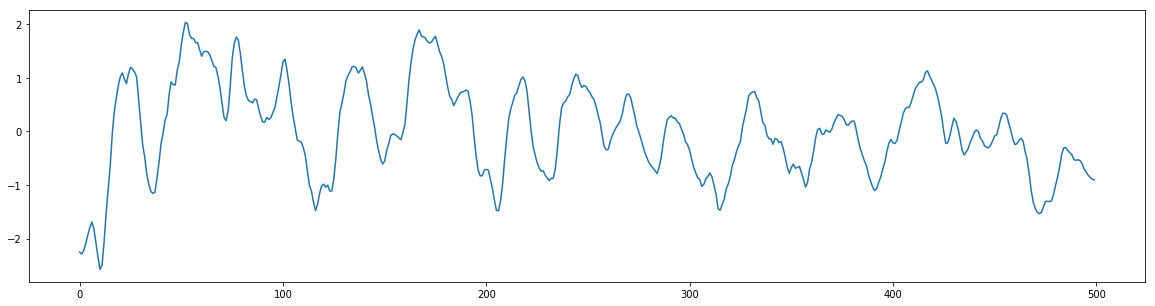

In [6]:
render_y(Y_diff, start=0, end=500)

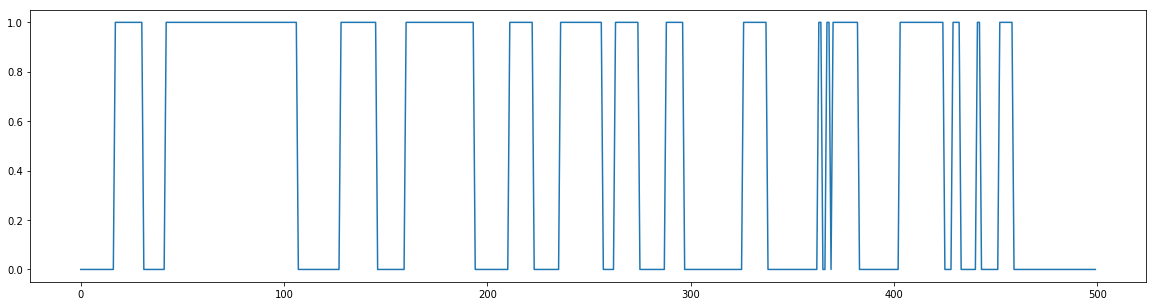

In [7]:
render_y(Y_category, start=0, end=500)

(100, 6)


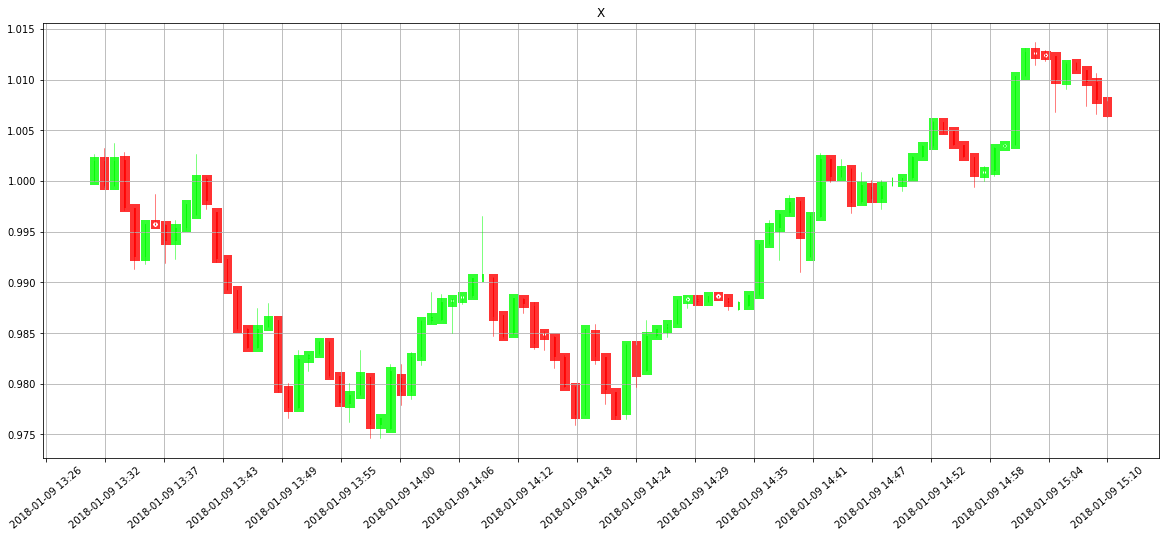

In [8]:
render_X(X_episode, start=0, end=100)

In [9]:
# train / test
def create_dataset(state, episode_size, look_ahead, filter_padding=FILTER_PADDING, step=1):
    episodes_count = get_state_episodes_count(state, episode_size, look_ahead)
    length = episodes_count // step
    print("Episodes:", episodes_count, "Length:", length)
    features_number = get_features_number(state)
    
    X_set = np.zeros((length, features_number, episode_size-look_ahead-filter_padding))
    Y_diff = np.zeros((length, 1))
    Y_category = np.zeros((length, 1))
    
    for i in range(length):
        X, yd, yc = get_episode_data(state, start_index=i*step, episode_size=episode_size, look_ahead=look_ahead, final_y_label=True)
        X_set[i, :, :] = X.T[1:,:]
        Y_diff[i], Y_category[i] = yd, yc
        if i % 5000 == 0:
            print("Processed: ", i)
    return X_set, Y_diff, Y_category

In [10]:
X_set_train, Y_diff_train, Y_category_train = create_dataset(train_state, EPISODE_SIZE, LOOK_AHEAD, step=5)

Episodes: 686065 Length: 137213
Processed:  0
Processed:  5000
Processed:  10000
Processed:  15000
Processed:  20000
Processed:  25000
Processed:  30000
Processed:  35000
Processed:  40000
Processed:  45000
Processed:  50000
Processed:  55000
Processed:  60000
Processed:  65000
Processed:  70000
Processed:  75000
Processed:  80000
Processed:  85000
Processed:  90000
Processed:  95000
Processed:  100000
Processed:  105000
Processed:  110000
Processed:  115000
Processed:  120000
Processed:  125000
Processed:  130000
Processed:  135000


(701, 5)


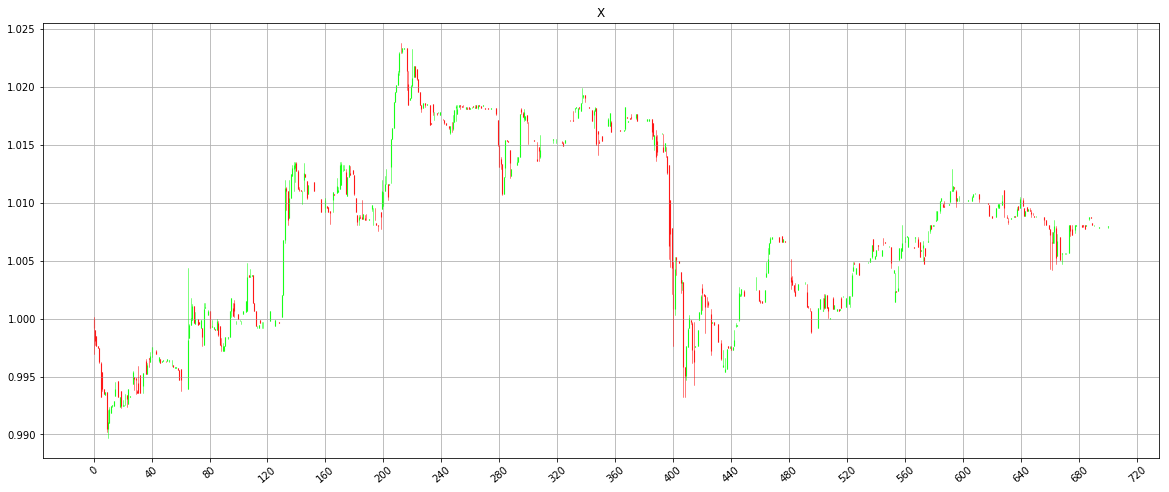

In [12]:
render_X(X_set_train[0].T, start=0, end=701)

In [14]:
# Let's test y_data
Y_diff_train[1][0], Y_category_train[1][0]
# Get raw data
start_index, episode_size, look_ahead = 5, EPISODE_SIZE, LOOK_AHEAD
episode_state = train_state[start_index : start_index + episode_size].copy()
Y_diff_final, Y_category_final = get_y_label_final(episode_state, look_ahead)
Y_diff_episode, Y_category_episode = get_y_label_episode(episode_state, look_ahead)
#
assert(Y_diff_train[1][0] == Y_diff_final == Y_diff_episode[-1])
assert(Y_category_train[1][0] == Y_category_final == Y_category_episode[-1])

In [15]:
X_set_test, Y_diff_test, Y_category_test = create_dataset(test_state, EPISODE_SIZE, LOOK_AHEAD, step=5)

Episodes: 120465 Length: 24093
Processed:  0
Processed:  5000
Processed:  10000
Processed:  15000
Processed:  20000


In [28]:
FOLDER = os.path.join(os.getcwd(), '..', 'prepared_data/')
np.save(FOLDER + 'X_train.npy', X_set_train)
np.save(FOLDER + 'y_train.npy', Y_diff_train)
np.save(FOLDER + 'y_train_categories.npy', Y_category_train)
np.save(FOLDER + 'X_test.npy', X_set_test)
np.save(FOLDER + 'y_test.npy', Y_diff_test)
np.save(FOLDER + 'y_test_categories.npy', Y_category_test)